In [1]:
import requests
import pandas as pd
import numpy as np
import json
from bs4 import BeautifulSoup
import config
import logging
import importlib
import time
import random
from selenium import webdriver
from selenium.webdriver.common.by import By 
from selenium.webdriver.support.ui import WebDriverWait 
from selenium.webdriver.support import expected_conditions as EC 
from selenium.common.exceptions import TimeoutException
import validators
import pickle
import time
import random
from calendar import monthrange
import re
import spacy
from spacy.tokens import Doc, Span
import nltk
from nltk.corpus import stopwords
from nltk.corpus import treebank
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.corpus import wordnet

from nltk import pos_tag, sent_tokenize, wordpunct_tokenize

pd.options.display.max_columns = 300
import string
import unicodedata

pd.options.display.max_columns = 200
pd.options.display.max_rows = 999
import matplotlib.pyplot as plt  

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as datasets
import pandas as pd
import numpy as np
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.metrics import mean_squared_error
from pandas.plotting import scatter_matrix
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.externals import joblib
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn import tree 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.externals.six import StringIO  
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.svm import SVC  
from time import time
np.random.seed(0)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfTransformer


import gensim
from gensim import corpora
from gensim import models
from gensim.sklearn_api import lsimodel, ldamodel
from gensim.matutils import sparse2full
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel

import pyLDAvis
import pyLDAvis.gensim

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from functools import partial
from operator import itemgetter
from joblib import dump, load

/Users/markbrennan/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/markbrennan/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Get our full populate of clean news articles (across three sources:  NYT, FT, Reuters).

In [69]:
with open('objects/full_sampled_pop-new-bi.pkl', 'rb') as f:
    news_df = pickle.load(f)

In [70]:
len(news_df)

6669

In [71]:
news_df.rename(columns={'bigrammed_text': 'docs'}, inplace=True)

In [72]:
news_df.head()

,paper,docs,text
240,NYT,"[allies, president, vladimir, v, russia, suffe...",MOSCOW — Allies of President Vladimir V. Putin...
2306,NYT,"[president, warn, tuesday, attack, iran, might...",WASHINGTON — President Trump warned on Tuesday...
2106,RT,"[german, government, friday, present, far-reac...",FRANKFURT/The German government on Friday pres...
236,FT,"[many, mexican, business, people, armando, san...","Like many Mexican business people, Armando San..."
333,FT,"[charles, li, chief, executive, hong_kong, exc...","Charles Li, chief executive of Hong Kong Excha..."


In [221]:
news_doc_pop_df = news_df[['paper', 'text']]

In [224]:
len(news_doc_pop_df)

6669

In [225]:
with open('news_doc_pop_df.pkl', 'wb') as f:
    pickle.dump(news_doc_pop_df, f)

## "Stringify" our doc tokens for SKLearn

In [73]:
news_df['docs_text'] = news_df.docs.apply(lambda x: ' '.join(x))

In [74]:
news_df.head()

,paper,docs,text,docs_text
240,NYT,"[allies, president, vladimir, v, russia, suffe...",MOSCOW — Allies of President Vladimir V. Putin...,allies president vladimir v russia suffer sign...
2306,NYT,"[president, warn, tuesday, attack, iran, might...",WASHINGTON — President Trump warned on Tuesday...,president warn tuesday attack iran might carry...
2106,RT,"[german, government, friday, present, far-reac...",FRANKFURT/The German government on Friday pres...,german government friday present far-reaching ...
236,FT,"[many, mexican, business, people, armando, san...","Like many Mexican business people, Armando San...",many mexican business people armando santacruz...
333,FT,"[charles, li, chief, executive, hong_kong, exc...","Charles Li, chief executive of Hong Kong Excha...",charles li chief executive hong_kong exchanges...


## Pull out our features and labels and run train test split

In [75]:
X_all = news_df[['docs_text','text']]

In [76]:
X_all.head()

,docs_text,text
240,allies president vladimir v russia suffer sign...,MOSCOW — Allies of President Vladimir V. Putin...
2306,president warn tuesday attack iran might carry...,WASHINGTON — President Trump warned on Tuesday...
2106,german government friday present far-reaching ...,FRANKFURT/The German government on Friday pres...
236,many mexican business people armando santacruz...,"Like many Mexican business people, Armando San..."
333,charles li chief executive hong_kong exchanges...,"Charles Li, chief executive of Hong Kong Excha..."


In [77]:
y_all = news_df[['paper']]

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size = 0.2, random_state = 42)

In [79]:
X_train.head()

,docs_text,text
2158,priests robe hard hat worship saturday cathedr...,PARIS — Priests in robes and hard hats worship...
1722,death toll earthquake pakistan tuesday risen m...,The death toll from an earthquake in Pakistan ...
1009,military court algeria sentence bouteflika you...,A military court in Algeria has sentenced Said...
657,united_states endorse turkey plan offensive no...,The United States does not endorse Turkey’s pl...
1697,reporters without borders advocate press freed...,"LONDON — Reporters Without Borders, which advo..."


## Get a TF-IDF Vector and try to model with that (first)

In [91]:
tfidf = TfidfVectorizer(stop_words='english', min_df=5, max_df=.5)

In [92]:
X_train_tfidf_vec = tfidf.fit_transform(X_train.docs_text)

## Persist our TF-IDF Vector Transformer

In [93]:
dump(tfidf, 'objects/tfidf-new-bi.joblib')

['objects/tfidf-new-bi.joblib']

## Now that our TF-IDF vector is fitted on our training data, transform our test data

In [94]:
X_test_idf_vec = tfidf.transform(X_test.docs_text)

## Get our TF-IDF word frequency counts

In [95]:
sum_words = X_train_tfidf_vec.sum(axis=0) 

In [96]:
tfidf_word_metrics = [(word, sum_words[0, idx]) for word, idx in     tfidf.vocabulary_.items()]

In [97]:
sorted_tfidf_word_metrics = sorted(tfidf_word_metrics, key = lambda x: x[1], reverse=True)

In [98]:
sorted_tfidf_word_metrics[:25]

[('brexit', 116.02062374056221),
 ('iran', 115.64264168413034),
 ('china', 111.92425059772444),
 ('president', 107.17569702676063),
 ('party', 105.48059001250586),
 ('police', 101.49574075322097),
 ('hong_kong', 101.02173442836332),
 ('deal', 99.71336890177813),
 ('minister', 97.84916933053576),
 ('official', 84.32932375946915),
 ('attack', 83.74876395310996),
 ('delay', 82.60759815029402),
 ('state', 80.54778658261667),
 ('exchange', 80.38976212317519),
 ('quote', 80.2149345547498),
 ('list', 79.56296422561789),
 ('reporting', 79.56246859225217),
 ('election', 79.33260807877714),
 ('complete', 78.96524259380162),
 ('saudi', 78.71739599049789),
 ('minute', 78.52153511359774),
 ('minimum', 78.19916482167231),
 ('delayed', 77.93979576214146),
 ('united_states', 76.64408991614916),
 ('prime', 74.93138477763291)]

In [24]:
X_train_tfidf_vec.shape

(5335, 16436)

## Visualize our TF-IDF Vector Words

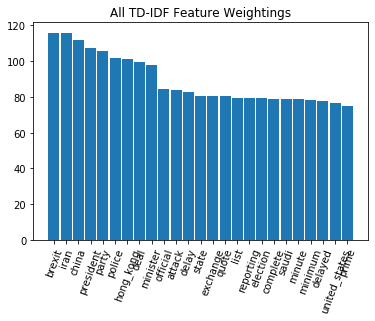

In [99]:
dum1 = sorted_tfidf_word_metrics[:25]

plt.bar(range(len(dum1)), [val[1] for val in dum1], width = 0.9, align='center')

# fig, ax = plt.subplots()
#ax.barh(range(len(dum1)), [val[1] for val in dum1], align='center')

plt.xticks(range(len(dum1)), [val[0] for val in dum1])
#ax.set_yticks([val[1] for val in dum1])

plt.xticks(rotation=70)

#ax.xticks(rotation=70)
# ax.set_xticks(ax.get_xticks()[::2])

# plt.figure(figsize=(30, 3))
plt.title('All TD-IDF Feature Weightings') 
plt.savefig('all-tdidf.png')
plt.show()


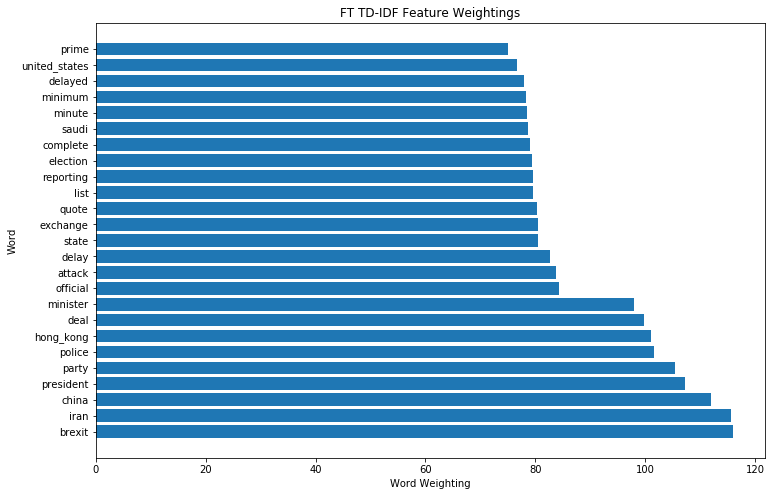

In [118]:
#n_features = data_train.shape[1]
plt.figure(figsize=(12,8))
#plt.barh(range(n_features), model.feature_importances_, align='center') 
plt.barh(range(len(dum1)), [val[1] for val in dum1], align='center') 

#plt.yticks(np.arange(n_features), data_train.columns.values) 
plt.yticks(range(len(dum1)), [val[0] for val in dum1]) 

plt.xlabel("Word Weighting")
plt.ylabel("Word")
plt.title('FT TD-IDF Feature Weightings')
plt.savefig('all-tdidf.png')
plt.show()

## Helper function to print model metrics

In [45]:
def print_metrics(test, preds):
    print("Precision Score: {}".format(precision_score(test, preds, average='macro')))
    print("Recall Score: {}".format(recall_score(test, preds, average='macro')))
    print("Accuracy Score: {}".format(accuracy_score(test, preds)))
    print("F1 Score: {}".format(f1_score(test, preds, average='macro')))

## First do a "dummy" classifier to obtain a baseline

In [100]:
dummy = DummyClassifier()
dummy.fit(X_train_tfidf_vec.toarray(), y_train)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [101]:
dum_pred = dummy.predict(X_test_idf_vec)

In [102]:
print_metrics(y_test, dum_pred)

Precision Score: 0.3384535481095057
Recall Score: 0.33813254641827317
Accuracy Score: 0.34632683658170915
F1 Score: 0.33811027220233614


In [103]:
model = GaussianNB()

# Train the model using the training sets
model.fit(X_train_tfidf_vec.toarray(), y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

## Persist our GaussianNB Model

In [104]:
dump(model, 'objects/gnb-model-new-bi.joblib')

['objects/gnb-model-new-bi.joblib']

In [105]:
train_pred = model.predict(X_train_tfidf_vec.toarray())

In [106]:
print_metrics(y_train, train_pred)

Precision Score: 0.9952284585927518
Recall Score: 0.9950009753246744
Accuracy Score: 0.9949390815370197
F1 Score: 0.9950922474126408


In [107]:
pred = model.predict(X_test_idf_vec.toarray())

In [108]:
## First metrics, before re-fitting
print_metrics(y_test, pred)

Precision Score: 0.9151177311263264
Recall Score: 0.917027929107345
Accuracy Score: 0.9145427286356822
F1 Score: 0.9145880164658952


## Try Decision Tree

In [109]:
clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(X_train_tfidf_vec.toarray(), y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [110]:
dump(model, 'objects/dt-model-new-bi.joblib')

['objects/dt-model-new-bi.joblib']

In [111]:
dt_pred = clf.predict(X_test_idf_vec.toarray())

In [112]:
print_metrics(y_test, dt_pred)

Precision Score: 0.9645439265264106
Recall Score: 0.9643320675868443
Accuracy Score: 0.9677661169415293
F1 Score: 0.964437008061943


## Test with our training data, too

In [47]:
dt_train_pred = clf.predict(X_train_tfidf_vec.toarray())

In [48]:
print_metrics(y_train, dt_train_pred)

Precision Score: 1.0
Recall Score: 1.0
Accuracy Score: 1.0
F1 Score: 1.0


## Confusion Matrix Visuals

### Helper Function

In [113]:
def plot_confusion_matrix(y_true, y_pred, normalize=False, title=None, cmap=plt.cm.Reds):
    labels = ['NYT', 'FT', 'RT']
    # Compute confusion matrix
    cmat = pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)
    print(cmat)
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='True Classification',
           xlabel='Predicted Classification')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=1)
# Plot non-normalized confusion matrix
plt.show()

Predicted   FT  NYT   RT   All
True                          
FT         328   20    5   353
NYT         14  447    9   470
RT          22   44  445   511
All        364  511  459  1334


<function matplotlib.pyplot.show(*args, **kw)>

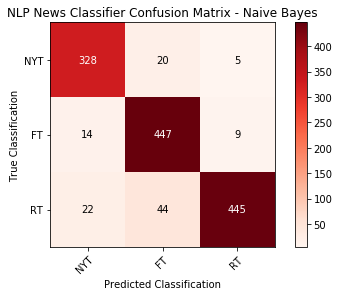

In [116]:
plot_confusion_matrix(y_test['paper'].to_numpy(), pred)
plt.title('NLP News Classifier Confusion Matrix - Naive Bayes')
plt.savefig('ConfusionMatrix-NB.png')
plt.show

Predicted   FT  NYT   RT   All
True                          
FT         331   22    0   353
NYT         21  449    0   470
RT           0    0  511   511
All        352  471  511  1334


<function matplotlib.pyplot.show(*args, **kw)>

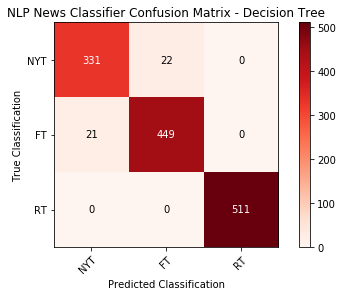

In [117]:
plot_confusion_matrix(y_test['paper'].to_numpy(), dt_pred)
plt.title('NLP News Classifier Confusion Matrix - Decision Tree')
plt.savefig('ConfusionMatrix-DT.png')
plt.show

In [51]:
ft_text = '''A Russian cyber espionage unit has hacked Iranian hackers to lead attacks in more than 35 countries, a joint UK and US investigation has revealed.

The so-called Turla group, which has been linked with Russian intelligence, allegedly hijacked the tools of Oilrig, a group widely linked to the Iranian government, according to a two-year probe by the UK’s National Cyber Security Centre in collaboration with the US’ National Security Agency. The NCSC is part of GCHQ, the digital intelligence agency.

The Iranian group is most likely unaware that its hacking methods have been hacked and deployed by another cyber espionage team, security officials involved in the investigation said. Victims include military establishments, government departments, scientific organisations and universities across the world, mainly in the Middle East.

Paul Chichester, NCSC director of operations, said Turla’s activity represented “a real change in the modus operandi of cyber actors” which he said “added to the sense of confusion” over which state-backed cyber groups had been responsible for successful attacks.

“The reason we are [publicising] this is because of the different tradecraft we are seeing Turla use,” he told reporters. “We want others to be able to understand this activity.”

Mr Chichester described how Turla began “piggybacking” on Oilrig’s attacks by monitoring an Iranian hack closely enough to use the same backdoor route into an organisation or to gain access to the resulting intelligence. Turla is also known as Waterbug or Venomous Bear.

But the Russian group then progressed to initiating their own attacks using Oilrig’s command-and-control infrastructure and software. Organisations in approximately 20 countries were successfully hacked in this way.

“[Turla] could benefit from the operations of Oilrig. They could collect some of their operational output . . . It allowed them to gain more rapid access to victims than they would otherwise have done,” Mr Chichester said. “It made life much easier. This is an opportunistic operation which has given [Turla] a wealth of information and access they wouldn’t otherwise have had.”

The Kremlin did not respond to a request for comment from the Financial Times. Russia’s government has consistently denied it is behind hacking attempts on other states. President Vladimir Putin, in an interview with the FT earlier this year, described allegations that Moscow had orchestrated attempts to influence the 2016 US elections as “mythical”.

Cyber espionage groups are increasingly concealing their identities under so called “false flag” operations — in which they try to mimic the activities of another group. Last year US intelligence agencies were reported to have uncovered the fact that Russian hackers had attempted to disrupt the Winter Olympics in Pyeongchang, South Korea, using lines of code associated with Lazarus Group, attributed to North Korea.

But NCSC says Turla’s operations go far further than imitation, and that Oilrig itself — also known by the names Crambus and APT34 — was hacked.

“We have never seen this done to the level of sophistication that we are seeing here,” Mr Chichester said. “It’s unique in the complexity and scale and sophistication. It’s actually really hard masquerading [as another entity].”

He said that Turla now had the potential to hijack other state-sponsored cyber groups. “This is becoming a very crowded space and we do see people innovate quite rapidly in that domain,” he said.'''

In [52]:
ft_text

'A Russian cyber espionage unit has hacked Iranian hackers to lead attacks in more than 35 countries, a joint UK and US investigation has revealed.\n\nThe so-called Turla group, which has been linked with Russian intelligence, allegedly hijacked the tools of Oilrig, a group widely linked to the Iranian government, according to a two-year probe by the UK’s National Cyber Security Centre in collaboration with the US’ National Security Agency. The NCSC is part of GCHQ, the digital intelligence agency.\n\nThe Iranian group is most likely unaware that its hacking methods have been hacked and deployed by another cyber espionage team, security officials involved in the investigation said. Victims include military establishments, government departments, scientific organisations and universities across the world, mainly in the Middle East.\n\nPaul Chichester, NCSC director of operations, said Turla’s activity represented “a real change in the modus operandi of cyber actors” which he said “added

In [226]:
with open('test_article.pkl', 'wb') as f:
    pickle.dump(ft_text, f)

## Gotta move this class and this function to a module!

In [53]:

class TextNormalizer(BaseEstimator, TransformerMixin):
    def __init__(self, language='english', source=None):
        self.source = source
        self.stopwords = set(nltk.corpus.stopwords.words(language))
        self.more_stops = {'mr', 'ms', 'mr.', 'ms.', 'mrs', 'mrs.','say', 'said', 'saying', 
                           'also', 'yeh', 'hom', 'even', 'like', 'k', 'n', 'u', 'would', 'could', '$'}
        self.stopwords.update(self.more_stops) 
        self.lemmatizer = WordNetLemmatizer()

    def is_punct(self, token):
        return all(unicodedata.category(char).startswith('P') for char in token)

    def is_stopword(self, token):
        return token.lower() in self.stopwords
    
    def get_stopwords(self):
        return self.stopwords

    def get_wordnet_pos(selfm, word):
        #Map POS tag to first character lemmatize() 
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}

        return tag_dict.get(tag, wordnet.NOUN)

    def normalize(self, document):
        NYT_PAT = '^[A-Z]* — '
        NYT_COMP_PAT = re.compile(NYT_PAT)        
        
        norm_toks = []
    
        if self.source and self.source == 'NYT':
            document = NYT_COMP_PAT.sub('', document)
# I found nltk's sentenizer to perform poorly
#        for sent in sent_tokenize(document):
        for sent in document.split('.'):            
            for tok in nltk.word_tokenize(sent):
                if self.is_punct(tok) or tok.isdigit():
                    continue
                lem = self.lemmatize(tok, self.get_wordnet_pos(tok)).lower()
                if not self.is_stopword(lem):
                    norm_toks.append(lem) 
                
        return norm_toks


    def lemmatize(self, token, pos):
        return self.lemmatizer.lemmatize(token, pos)

    def fit(self, X, y=None):
        return self

    def transform(self, documents):
        for doc in documents:
            yield self.normalize(document)

In [54]:
# code to pull out our custom bi-grams
bigrams = ['donald trump', 'angela merkel', 'boris johnson', 'vladimir putin', 'benjamin netanyahu', 
           'hong kong', 'north korea', 'south korea', 'united kingdom', 'united states', 'south africa', 
           'xi jinping', 'carrie lam', 'oleksiy honcharuk', 'volodymyr zelensky', 'emmanuel macron',
           'viktor orbán', 'justin trudeau', 'north america', 'south america', 'sinn fein', 'jeremy corbyn', 'narendra modi',
            'mohamed morsi', 'shuping wang', 'hassan rouhani', 'rudy giuliani', 'joe biden', 'new zealand', 'european union', 'pope francis']

In [55]:
class BiGramTransformer:
    def __init__(self, bigram_list):
        self.bigram_list = bigram_list        
        self.first_grams = [word.split()[0] for word in bigram_list]
        self.second_grams = [word.split()[1] for word in bigram_list]

    def get_custom_bigrams(self, tokens):
        new_toks = []
        length = len(tokens)

        for ix, tok in enumerate(tokens):
            try:
                if tok in self.first_grams:
                    if ix+1 <= length and tokens[ix+1] in self.second_grams:
                        new_toks.append(' '.join([tok, tokens[ix+1]]))
                        continue
                if tok in self.second_grams:
                    # we assume if we see the 2nd token in a bigram that
                    # we've already prcessed the first and second together
                    # so skip 
                    continue
                new_toks.append(tok)
            except IndexError:
                continue

        return new_toks

In [56]:
txtNorm = TextNormalizer()

In [58]:
ft_text_txfm = txtNorm.normalize(ft_text)

In [59]:
bigram_txfm = BiGramTransformer(bigrams)

In [60]:
ft_text_bi = bigram_txfm.get_custom_bigrams(ft_text_txfm)

['russian',
 'cyber',
 'espionage',
 'unit',
 'hack',
 'iranian',
 'hacker',
 'lead',
 'attack',
 'country',
 'joint',
 'uk',
 'us',
 'investigation',
 'reveal',
 'so-called',
 'turla',
 'group',
 'link',
 'russian',
 'intelligence',
 'allegedly',
 'hijack',
 'tool',
 'oilrig',
 'group',
 'widely',
 'link',
 'iranian',
 'government',
 'accord',
 'two-year',
 'probe',
 'uk',
 'national',
 'cyber',
 'security',
 'centre',
 'collaboration',
 'us',
 'national',
 'security',
 'agency',
 'ncsc',
 'part',
 'gchq',
 'digital',
 'intelligence',
 'agency',
 'iranian',
 'group',
 'likely',
 'unaware',
 'hack',
 'method',
 'hack',
 'deployed',
 'another',
 'cyber',
 'espionage',
 'team',
 'security',
 'official',
 'involve',
 'investigation',
 'victims',
 'include',
 'military',
 'establishment',
 'government',
 'department',
 'scientific',
 'organisation',
 'university',
 'across',
 'world',
 'mainly',
 'middle',
 'east',
 'paul',
 'chichester',
 'ncsc',
 'director',
 'operation',
 'turla',
 'act

In [62]:
ft_text_full_str = ' '.join(ft_text_bi)

In [66]:
ft_series = pd.Series(ft_text_full_str)

In [67]:
ft_test_label = pd.Series('FT')

In [68]:
ft_test_vec = tfidf.transform(ft_series)

In [69]:
ft_text_pred = model.predict(ft_test_vec.toarray())

In [70]:
print_metrics(ft_test_label, ft_text_pred)

Precision Score: 0.0
Recall Score: 0.0
Accuracy Score: 0.0
F1 Score: 0.0


In [71]:
ft_text_pred

array(['NYT'], dtype='<U3')

## Do some analysis using confusion matrix

In [77]:
 confusion_matrix(y_test, pred, labels=["NYT", "FT", "RT"])

array([[447,  14,   9],
       [ 17, 329,   7],
       [ 51,  25, 435]])

In [187]:
test_df = pd.DataFrame(y_test)

In [188]:
pred_df = pd.DataFrame(pred)

In [189]:
pred_df.reset_index(drop=True, inplace=True)

In [190]:
test_df.reset_index(drop=True, inplace=True)

In [191]:
X_test_copy = X_test.copy(deep=True)

In [192]:
X_test_copy.reset_index(drop=True, inplace=True)

In [193]:
X_test_copy.head()

,docs_text,text
0,british prime minister boris johnson sunday re...,"MANCHESTER, EnglandBritish Prime Minister Bori..."
1,seoul south korea north korea sunday two proje...,"SEOUL, South Korea — North Korea said on Sunda..."
2,pakistan ambassador united states raise possib...,Pakistan’s ambassador to the United States rai...
3,romford england regardless whether british vot...,"ROMFORD, England — Regardless of whether Briti..."
4,iran revolutionary guards seize vessel gulf al...,Iran’s Revolutionary Guards have seized a vess...


In [194]:
test_comp_df = pd.concat([pred_df,test_df,X_test_copy], ignore_index=True, axis=1)

In [197]:
test_comp_df.head()

,Predicted,Test,Features,3
0,RT,RT,british prime minister boris johnson sunday re...,"MANCHESTER, EnglandBritish Prime Minister Bori..."
1,NYT,NYT,seoul south korea north korea sunday two proje...,"SEOUL, South Korea — North Korea said on Sunda..."
2,NYT,NYT,pakistan ambassador united states raise possib...,Pakistan’s ambassador to the United States rai...
3,FT,NYT,romford england regardless whether british vot...,"ROMFORD, England — Regardless of whether Briti..."
4,RT,RT,iran revolutionary guards seize vessel gulf al...,Iran’s Revolutionary Guards have seized a vess...


In [201]:
test_comp_df.rename(columns={0:'Predicted', 1:'Test', 2:'Features', 3:'Text'}, inplace=True)

In [211]:
test_comp_df.head(100)

,Predicted,Test,Features,Text
0,RT,RT,british prime minister boris johnson sunday re...,"MANCHESTER, EnglandBritish Prime Minister Bori..."
1,NYT,NYT,seoul south korea north korea sunday two proje...,"SEOUL, South Korea — North Korea said on Sunda..."
2,NYT,NYT,pakistan ambassador united states raise possib...,Pakistan’s ambassador to the United States rai...
3,FT,NYT,romford england regardless whether british vot...,"ROMFORD, England — Regardless of whether Briti..."
4,RT,RT,iran revolutionary guards seize vessel gulf al...,Iran’s Revolutionary Guards have seized a vess...
5,RT,RT,-backed syrian democratic forces saturday hesi...,The U.S.-backed Syrian Democratic Forces said ...
6,NYT,NYT,auckland new zealand standoff indigenous group...,"AUCKLAND, New Zealand — A standoff between Ind..."
7,NYT,NYT,ursula von der leyen incoming chief european u...,"BRUSSELS — When Ursula von der Leyen, the inco..."
8,RT,RT,head group eurosceptic lawmaker prime minister...,The head of a group of eurosceptic lawmakers i...
9,RT,FT,administration issue visa iranian president ha...,The Trump administration has issued visas to I...


In [202]:
test_analysis_df = pd.DataFrame(test_comp_df[test_comp_df.Predicted != test_comp_df.Test])

In [203]:
len(test_analysis_df)

123

In [209]:
test_analysis_df.reset_index(drop=True, inplace=True)

In [210]:
test_analysis_df.head(123)

,Predicted,Test,Features,Text
0,FT,NYT,romford england regardless whether british vot...,"ROMFORD, England — Regardless of whether Briti..."
1,RT,FT,administration issue visa iranian president ha...,The Trump administration has issued visas to I...
2,NYT,RT,survivor relative men die nine year ago one ne...,(Reuters) - A survivor and relatives of 29 men...
3,NYT,FT,hardcore pro-democracy protester left trail ha...,Hardcore pro-democracy protesters left a trail...
4,NYT,RT,democratic republic congoa landslide shutter g...,"GOMA, Democratic Republic of CongoA landslide ..."
5,FT,RT,kuwait strategic foodstuff reserve cover four ...,Kuwait has strategic foodstuff reserves to cov...
6,RT,NYT,indonesia constitutional court thursday reject...,BANGKOK — Indonesia’s Constitutional Court on ...
7,FT,RT,wis terry dittrich work donald trump re-electi...,"WAUKESHA, Wis.Terry Dittrich has been working ..."
8,FT,RT,ancient british structure old pyramid threaten...,"ORKNEY, ScotlandAncient British structures old..."
9,FT,NYT,evidence paris police department miss warn sig...,PARIS — Evidence that the Paris police departm...


In [214]:
test_comp_df.iloc[22].Text # NYT - correct prediction - 7482

'HONG KONG — For the second day in a row, thousands rallied on Sunday in Hong Kong to protest mob violence and what they say is police brutality against peaceful marchers. And for the second consecutive day, the police fired tear gas and rubber bullets at the throngs.On Saturday, riot police officers unleashed pepper spray and rubber bullets and clashed briefly with demonstrators in a train station in a northern town. Barely 24 hours later, clashes erupted again that turned parts of downtown Hong Kong into a tear gas-filled battlefield as riot officers beat back demonstrators who tried to approach the Chinese government’s representative office in the territory.The police on Sunday fired dozens of rounds of tear gas starting from about 7 p.m. and charged protesters, sending hundreds of bystanders who were watching nearby scrambling for shelter. Groups of riot officers with clubs chased black-clad protesters down alleys in the dense urban district.In some areas, as the police sought to d

In [216]:
test_analysis_df.iloc[15].Text # Predicted FT - but NYT - 7202

'HONG KONG — Southeast Asian countries tend to be deeply reluctant to collectively challenge China’s growing military and economic prowess in their region. But this week, they appear to be doing just that — by holding their first joint naval drills with the United States Navy.The drills, which will take place partly in the South China Sea, a site of geopolitical tension, began on Monday. They were not expected to focus on lethal maneuvers, or to take place in contested waters where China operates military bases.But the maneuvers follow similar exercises held last year by China and the 10-member Association of Southeast Asian Nations in an undisputed area of the sea, making them a riposte of sorts to Beijing.During a summer of heightened tensions over territorial claims, plus an escalating trade war between China and the United States, the drills are being closely watched as the latest move in a high-stakes geopolitical chess match between the superpowers and their shared regional allie

In [218]:
test_analysis_df.iloc[3].Text # Predicted NYT - but FT - 3557

'Hardcore pro-democracy protesters left a trail of havoc and destruction across Hong Kong on Sunday, marching in defiance of a police ban and targeting government buildings and subway stations with vandalism.\nThe day’s violence, which began with masked demonstrators hurling petrol bombs and smashing windows at Admiralty and Wan Chai stations marked the 15th straight weekend that protests have gripped the city and raised questions over how the Asian financial hub’s future will be shaped.\nThe economic effects of the three-month crisis were brought into sharp focus on Sunday when Hong Kong International Airport released figures showing it had seen its biggest monthly drop in passengers for a decade in August as the protests prompted tourist and business visitors to cancel trips.\nFew see any signs of an imminent return to calm. “We are never going to back down before Beijing does,” said one 28-year-old protester who gave his name as Peter. “We have fought for 100 days now. What makes an

In [157]:
test_analysis_df.columns

Index(['Predicted', 'Test', 'Features'], dtype='object')